In [3]:
import re
import pandas as pd
from pathlib import Path

FILE = Path("/Users/danarapp/Desktop/energypattern-keyword-search/processing_pipeline/analysis/analyzed_matches/second_iteration.xlsx")

SHEETS = [
    "git_datatransfer",
    "comments_datatransfer",
    "git_UI",
    "comments_UI",
    "git_code_optimization",
    "comments_code_optimization",
]

REVIEW_COLS = ["row_id", "matched_word", "sentence", "source", "url", "pattern", "commit_url", "comment"]

# --- Helpers ---------------------------------------------------------------

_hlx = re.compile(r'^=HYPERLINK\(\s*"([^"]+)"\s*,\s*"[^"]*"\s*\)$', flags=re.IGNORECASE)

def from_hyperlink(cell):
    """Extract raw URL from Excel HYPERLINK formula; otherwise return the original value."""
    if pd.isna(cell):
        return ""
    if isinstance(cell, str):
        m = _hlx.match(cell.strip())
        if m:
            return m.group(1)
        return cell.strip()
    return str(cell)

def ensure_schema(df: pd.DataFrame) -> pd.DataFrame:
    """Make sure required columns exist with sane defaults."""
    d = df.copy()
    for col in REVIEW_COLS:
        if col not in d.columns:
            d[col] = ""  # default empty if missing
    # row_id often comes back as float from Excel; coerce to Int64 if possible
    if "row_id" in d.columns:
        d["row_id"] = pd.to_numeric(d["row_id"], errors="coerce").astype("Int64")
    # strip hyperlink formulas to raw URLs
    for c in ("url", "commit_url"):
        if c in d.columns:
            d[c] = d[c].apply(from_hyperlink)
    # keep only expected columns in a stable order
    return d.reindex(columns=REVIEW_COLS)

# --- Loaders ---------------------------------------------------------------

def load_review_workbook(path: str | Path, sheets=SHEETS) -> dict[str, pd.DataFrame]:
    """
    Read specified sheets and clean each DataFrame.
    Matches sheet names case-insensitively and skips missing ones.
    """
    # Read all sheet names first
    xl = pd.ExcelFile(path, engine="openpyxl")
    available = {name.lower(): name for name in xl.sheet_names}

    cleaned = {}
    for name in sheets:
        name_lower = name.lower()
        if name_lower not in available:
            print(f"⚠️  Sheet '{name}' not found in {path.name}, skipping.")
            continue
        df = xl.parse(available[name_lower], dtype=str)
        cleaned[name] = ensure_schema(df)
    return cleaned


def load_and_concat(path: str | Path, sheets=SHEETS) -> pd.DataFrame:
    """
    Load all sheets, clean, and concatenate into one DataFrame with a 'sheet' column.
    """
    parts = []
    for name, df in load_review_workbook(path, sheets).items():
        parts.append(df.assign(sheet=name))
    out = pd.concat(parts, ignore_index=True)
    return out



In [55]:
from pathlib import Path

# Paths
FILE_1 = Path("/Users/danarapp/Desktop/energypattern-keyword-search/processing_pipeline/analysis/analyzed_matches/second_iteration.xlsx")
FILE_2 = Path("/Users/danarapp/Desktop/energypattern-keyword-search/processing_pipeline/analysis/analyzed_matches/wagtail_pattern_verification.xlsx")

# Load both workbooks
df1 = load_and_concat(FILE_1)
df2 = load_and_concat(FILE_2)

# Combine them (ignore index to get a fresh continuous index)
df_all = pd.concat([df1, df2], ignore_index=True)

print(f"✅ Combined dataframe created with {len(df_all):,} total rows.")
print(f"📄 From file 1: {len(df1):,}, from file 2: {len(df2):,}")
print("🧩 Columns:", list(df_all.columns))
print("Sheets represented:", df_all['sheet'].unique())


✅ Combined dataframe created with 1,221 total rows.
📄 From file 1: 735, from file 2: 486
🧩 Columns: ['row_id', 'matched_word', 'sentence', 'source', 'url', 'pattern', 'commit_url', 'comment', 'sheet']
Sheets represented: ['git_datatransfer' 'comments_datatransfer' 'git_UI' 'comments_UI'
 'git_code_optimization' 'comments_code_optimization']


In [56]:
# Remove rows where source is 'release' or 'docs'
df_all = df_all[~df_all["source"].isin(["release", "docs"])].reset_index(drop=True)

print(f"✅ After filtering, {len(df_all):,} rows remain.")
print("Remaining sources and counts:\n")
print(df_all["source"].value_counts())


✅ After filtering, 1,122 rows remain.
Remaining sources and counts:

source
issue            592
issue_comment    411
code_comment     119
Name: count, dtype: int64


Summary (total vs. analyzed) per repo:

           total  analyzed
repo                      
wagtail      445       186
saleor       100        72
netbox       128        79
zulip        394        78
paperless     55        37


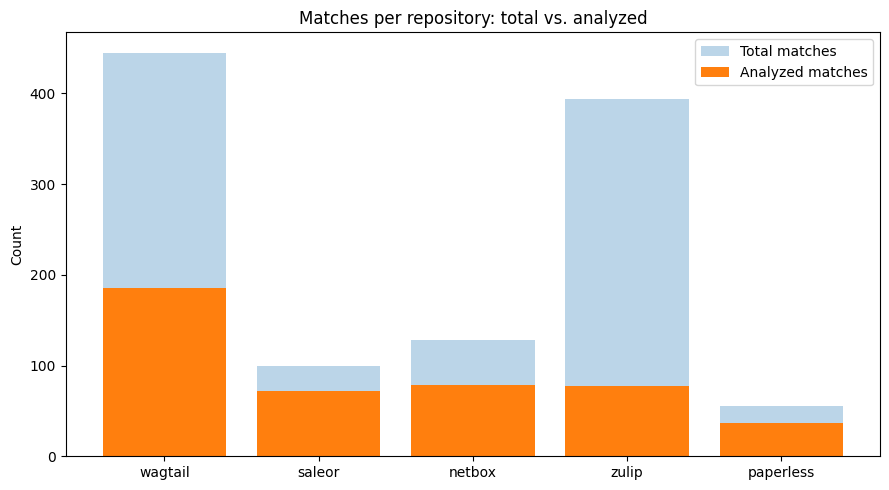

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure we have repo + analyzed columns (reuse your earlier logic)
def infer_repo(url: str) -> str:
    if not isinstance(url, str) or not url.strip():
        return "unknown"
    u = url.lower().strip()
    if u == "open":
        return "wagtail"
    for repo in ["saleor", "netbox", "zulip", "paperless"]:
        if repo in u:
            return repo
    return "unknown"

if "repo" not in df_all.columns:
    df_all["repo"] = df_all["url"].apply(infer_repo)

df_all["analyzed"] = df_all["pattern"].notna() & df_all["pattern"].astype(str).str.strip().ne("")

REPOS = ["wagtail", "saleor", "netbox", "zulip", "paperless"]

# Build summary with total + analyzed counts
repo_summary = (
    df_all[df_all["repo"].isin(REPOS)]
    .groupby("repo")
    .agg(total=("repo", "size"), analyzed=("analyzed", "sum"))
    .reindex(REPOS)
    .fillna(0)
    .astype({"total": int, "analyzed": int})
)

print("Summary (total vs. analyzed) per repo:\n")
print(repo_summary)

# Overlay bar chart: lighter (via alpha) total, solid analyzed
x = np.arange(len(repo_summary))
plt.figure(figsize=(9, 5))
plt.bar(x, repo_summary["total"].values, alpha=0.3, label="Total matches")
plt.bar(x, repo_summary["analyzed"].values, label="Analyzed matches")
plt.xticks(x, repo_summary.index, rotation=0)
plt.ylabel("Count")
plt.title("Matches per repository: total vs. analyzed")
plt.legend()
plt.tight_layout()
plt.show()


Counts per repo (git vs comments):

origin     comments  git
repo                    
wagtail          38  407
saleor            8   92
netbox           13  115
zulip            58  336
paperless         2   53


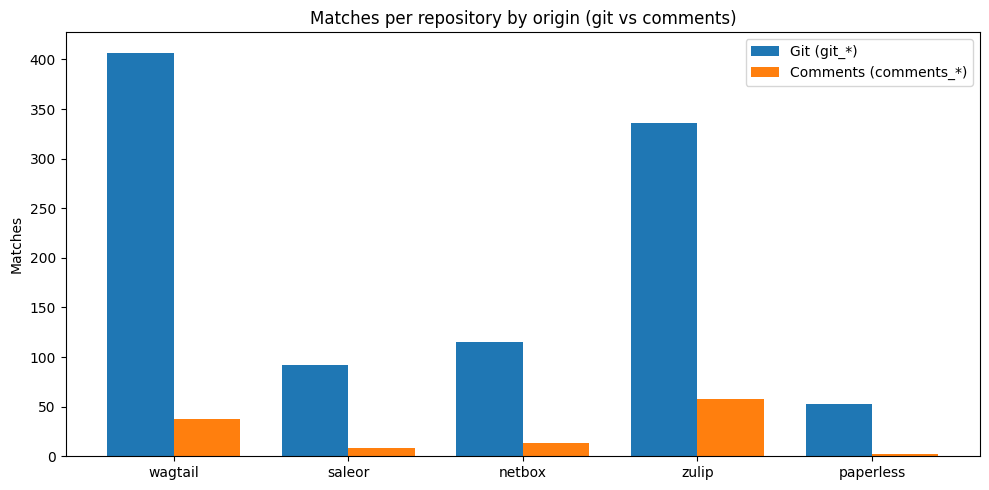

In [58]:
# Determine origin from sheet name: 'git_*' vs 'comments_*'
df_all["origin"] = np.where(
    df_all["sheet"].str.startswith("git_"), "git",
    np.where(df_all["sheet"].str.startswith("comments_"), "comments", "other")
)

# Focus on the five repos only
data = df_all[df_all["repo"].isin(REPOS) & df_all["origin"].isin(["git", "comments"])]

# Build counts table repo x origin
counts = (
    data.groupby(["repo", "origin"])
        .size()
        .unstack(fill_value=0)
        .reindex(REPOS)
)

print("Counts per repo (git vs comments):\n")
print(counts)

# Plot: two bars per repo (git vs comments)
x = np.arange(len(counts))
width = 0.38

plt.figure(figsize=(10, 5))
plt.bar(x - width/2, counts["git"], width, label="Git (git_*)")
plt.bar(x + width/2, counts["comments"], width, label="Comments (comments_*)")

plt.xticks(x, counts.index)
plt.ylabel("Matches")
plt.title("Matches per repository by origin (git vs comments)")
plt.legend()
plt.tight_layout()
plt.show()


Analyzed counts per repo (git vs comments):

origin     git  comments
repo                    
wagtail    149        37
saleor      64         8
netbox      66        13
zulip       33        45
paperless   35         2

False positive counts per repo (git vs comments):

origin     git  comments
repo                    
wagtail    121        35
saleor      59         5
netbox      59         4
zulip       22        16
paperless   32         0


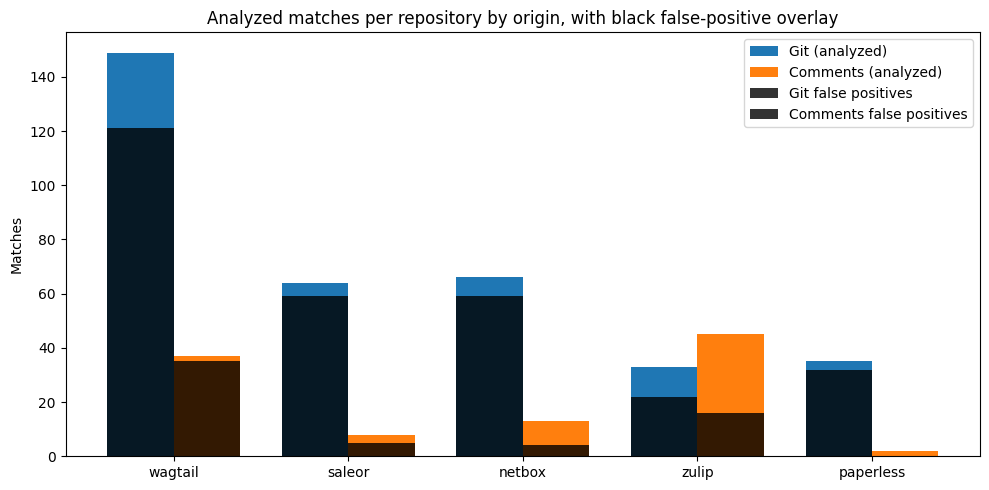

In [59]:
# Use only analyzed matches
analyzed_df = df_all[df_all["analyzed"]].copy()

# Determine origin from sheet name
analyzed_df["origin"] = np.where(
    analyzed_df["sheet"].str.startswith("git_"), "git",
    np.where(analyzed_df["sheet"].str.startswith("comments_"), "comments", "other")
)

# Filter to target repos and valid origins
flt = analyzed_df["repo"].isin(REPOS) & analyzed_df["origin"].isin(["git", "comments"])
data = analyzed_df[flt]

# Counts of analyzed matches per repo x origin
counts = (
    data.groupby(["repo", "origin"])
        .size()
        .unstack(fill_value=0)
        .reindex(REPOS)
        .reindex(columns=["git", "comments"], fill_value=0)
)

# Counts of false positives (pattern == 'false_positive') per repo x origin
fp_mask = data["pattern"].astype(str).str.strip().str.lower().eq("false_positive")
fp_counts = (
    data[fp_mask]
    .groupby(["repo", "origin"])
    .size()
    .unstack(fill_value=0)
    .reindex(REPOS)
    .reindex(columns=["git", "comments"], fill_value=0)
)

print("Analyzed counts per repo (git vs comments):\n")
print(counts)
print("\nFalse positive counts per repo (git vs comments):\n")
print(fp_counts)

# --- Plot: two bars per repo (git vs comments) with black overlay for false positives ---
x = np.arange(len(counts))
width = 0.38

plt.figure(figsize=(10, 5))

# Main bars = analyzed counts
plt.bar(x - width/2, counts["git"].values, width, label="Git (analyzed)")
plt.bar(x + width/2, counts["comments"].values, width, label="Comments (analyzed)")

# Overlay = false positives (always black)
plt.bar(x - width/2, fp_counts["git"].values, width, color="black", alpha=0.8, label="Git false positives")
plt.bar(x + width/2, fp_counts["comments"].values, width, color="black", alpha=0.8, label="Comments false positives")

plt.xticks(x, counts.index)
plt.ylabel("Matches")
plt.title("Analyzed matches per repository by origin, with black false-positive overlay")
plt.legend()
plt.tight_layout()
plt.show()


Analyzed counts per category (git vs comments):

origin             git  comments
category                        
datatransfer       228        35
ui                  52        40
code_optimization   67        30

False positive counts per category (git vs comments):

origin             git  comments
category                        
datatransfer       199        15
ui                  30        32
code_optimization   64        13


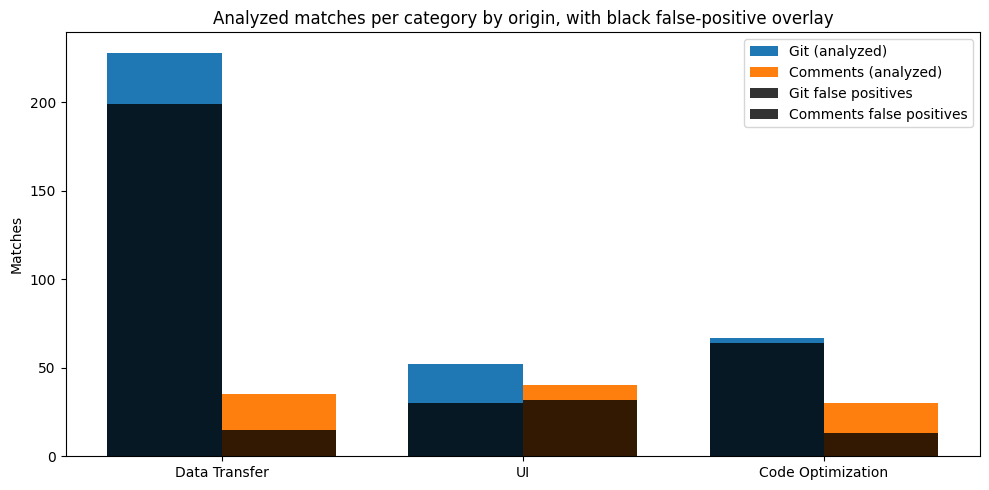

In [60]:
# --- Build "category" and "origin" columns on analyzed rows ---
analyzed_df = df_all[df_all["analyzed"]].copy()

# origin: git_* vs comments_*
analyzed_df["origin"] = np.where(
    analyzed_df["sheet"].str.startswith("git_"), "git",
    np.where(analyzed_df["sheet"].str.startswith("comments_"), "comments", "other")
)

# category: datatransfer / ui / code_optimization (case-insensitive, robust to sheet name variants)
sheets_lower = analyzed_df["sheet"].str.lower()
analyzed_df["category"] = np.select(
    [
        sheets_lower.str.contains("datatransfer"),
        sheets_lower.str.contains("code_optimization"),
        sheets_lower.str.contains("ui"),
    ],
    ["datatransfer", "code_optimization", "ui"],
    default="other"
)

CATEGORIES = ["datatransfer", "ui", "code_optimization"]

# Filter to your repos, valid origins, and the three categories
data = analyzed_df[
    analyzed_df["repo"].isin(REPOS)
    & analyzed_df["origin"].isin(["git", "comments"])
    & analyzed_df["category"].isin(CATEGORIES)
].copy()

# Counts of analyzed matches per category x origin
counts = (
    data.groupby(["category", "origin"])
        .size()
        .unstack(fill_value=0)
        .reindex(CATEGORIES)
        .reindex(columns=["git", "comments"], fill_value=0)
)

# Counts of false positives (pattern == 'false_positive') per category x origin
fp_mask = data["pattern"].astype(str).str.strip().str.lower().eq("false_positive")
fp_counts = (
    data[fp_mask]
    .groupby(["category", "origin"])
    .size()
    .unstack(fill_value=0)
    .reindex(CATEGORIES)
    .reindex(columns=["git", "comments"], fill_value=0)
)

print("Analyzed counts per category (git vs comments):\n")
print(counts)
print("\nFalse positive counts per category (git vs comments):\n")
print(fp_counts)

# --- Plot: two bars per category (git vs comments) with black overlay for false positives ---
x = np.arange(len(CATEGORIES))
width = 0.38

plt.figure(figsize=(10, 5))

# Main bars = analyzed counts
plt.bar(x - width/2, counts["git"].values, width, label="Git (analyzed)")
plt.bar(x + width/2, counts["comments"].values, width, label="Comments (analyzed)")

# Overlay = false positives (always black)
plt.bar(x - width/2, fp_counts["git"].values, width, color="black", alpha=0.8, label="Git false positives")
plt.bar(x + width/2, fp_counts["comments"].values, width, color="black", alpha=0.8, label="Comments false positives")

# Pretty x-axis labels
xtick_labels = ["Data Transfer", "UI", "Code Optimization"]
plt.xticks(x, xtick_labels)
plt.ylabel("Matches")
plt.title("Analyzed matches per category by origin, with black false-positive overlay")
plt.legend()
plt.tight_layout()
plt.show()


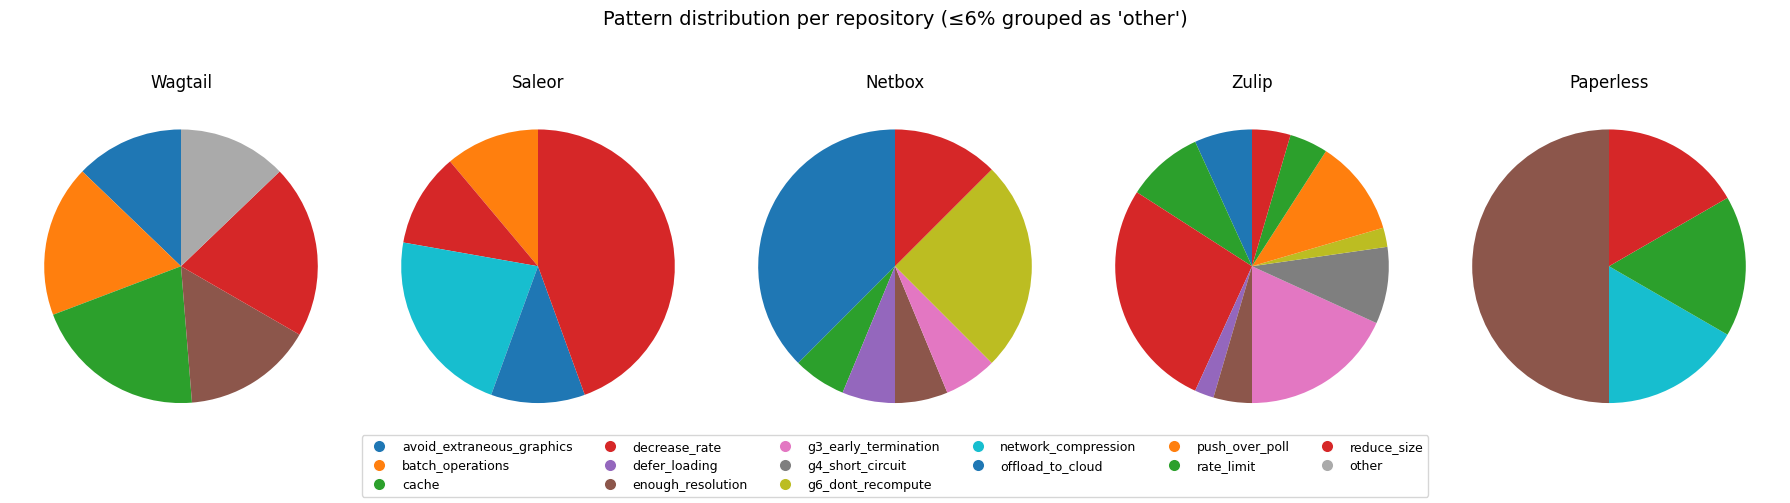

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# --- Keep analyzed, non-false-positive matches ---
valid_df = df_all[
    df_all["analyzed"]
    & df_all["pattern"].notna()
    & ~df_all["pattern"].astype(str).str.strip().str.lower().eq("false_positive")
].copy()

# --- Normalize & explode pattern column; merge "reduce size" -> "reduce_size" ---
norm = valid_df["pattern"].astype(str).str.lower().str.strip()
exploded = valid_df.copy()
exploded["pattern"] = norm.str.split(",")
exploded = exploded.explode("pattern")
exploded["pattern"] = (
    exploded["pattern"].astype(str).str.strip().replace({"reduce size": "reduce_size"})
)

# --- Count patterns per repo (consistent columns across repos) ---
all_patterns = sorted(exploded["pattern"].dropna().unique())
repo_pattern_counts = (
    exploded[exploded["repo"].isin(REPOS)]
    .groupby(["repo", "pattern"])
    .size()
    .unstack(fill_value=0)
    .reindex(REPOS)
    .reindex(columns=all_patterns, fill_value=0)
)

# --- Determine "major" patterns: >6% in at least one repo ---
shares = repo_pattern_counts.div(repo_pattern_counts.sum(axis=1), axis=0).fillna(0)
major_patterns = sorted([p for p in repo_pattern_counts.columns if (shares[p] > 0.06).any()])

# --- Colors: consistent per major pattern; gray for "other" ---
cycle = plt.rcParams["axes.prop_cycle"].by_key().get("color", []) or ["#1f77b4"]
repeats = (len(major_patterns) + len(cycle) - 1) // len(cycle)
palette = (cycle * repeats)[: len(major_patterns)]
color_map = dict(zip(major_patterns, palette))
OTHER_COLOR = "#aaaaaa"

# --- Plot pies; merge ≤6% into "other"; legend shows majors + one "other" entry ---
fig, axes = plt.subplots(1, len(REPOS), figsize=(18, 5))

for ax, repo in zip(axes, REPOS):
    counts = repo_pattern_counts.loc[repo]
    total = counts.sum()
    if total == 0:
        ax.text(0.5, 0.5, "No data", ha="center", va="center")
        ax.set_title(repo.capitalize())
        ax.axis("off")
        continue

    # Keep only major patterns explicitly; sum the rest into "other"
    main = counts[major_patterns].copy()
    other_val = (counts.sum() - main.sum())
    if other_val > 0:
        main["other"] = other_val

    # Build colors in order of main.index (majors have mapped colors; "other" is gray)
    colors = [color_map.get(p, OTHER_COLOR) for p in main.index]

    ax.pie(main.values, labels=None, startangle=90, colors=colors)
    ax.set_title(repo.capitalize())

plt.suptitle("Pattern distribution per repository (≤6% grouped as 'other')", fontsize=14)
plt.tight_layout(rect=[0, 0.08, 1, 0.92])

# Legend: only majors + single "other"
handles = [
    plt.Line2D([0], [0], marker="o", color="w",
               label=p, markerfacecolor=color_map[p], markersize=9)
    for p in major_patterns
] + [
    plt.Line2D([0], [0], marker="o", color="w",
               label="other", markerfacecolor=OTHER_COLOR, markersize=9)
]

fig.legend(handles=handles,
           loc="lower center",
           ncol=min(len(major_patterns) + 1, 6),
           fontsize=9)

plt.show()
